# GFlowNet tutorial
This tutorial is meant to be a fairly smooth introduction to Generative Flow Networks, with an emphasis on the "code perspective" that I know some prefer as a learning format.

I've been wanting to write a simple GFlowNet tutorial for a while, especially since the initial codebase that we released was hastily written and not very deeply commented.

What follows is meant to be simple code to help the reader understand GFlowNet and how to implement one, rather than code that is meant to run quickly and efficiently. I won't assume that the reader knows exactly what GFlowNet is, although having read any of the GFlowNet papers (or following along) and/or being familiar with Reinforcement Learning is a plus. I'm assuming the reader knows pytorch and deep learning basics.

For a thorough treatment of GFlowNet, checkout the [GFlowNet Foundations](https://arxiv.org/abs/2111.09266) paper by Yoshua Bengio, Salem Lahlou, Tristan Deleu, Edward J. Hu, Mo Tiwari, and myself.

---

GFlowNet (GFN) is a generative modeling framework. This means we're training models to sample from some distribution $p(x)$, i.e. there's a `sample()` function somewhere we can call to generate an object $x$.

What (we think) GFN is particularly good at is sampling _compositional_, discrete objects like graphs, sets, or even sequences. These objects are generated in a sequence, one part after the other, and we can think of the implementation of `sample()` as a `for` loop that generates each part in some order.

What distinguishes GFN from "dataset-based" generative methods is that we assume that we are given an unnormalized density function, or positive reward $R(x)$ which attributes some value to every possible object.

What distinguishes GFN from RL methods is that we use the reward to learn a particular $p(x)$, instead of trying to find reward-maximizing solutions. We are aiming to train a model such that $$p(x) \propto R(x).$$

I won't extoll the benefits of GFNs here, but if you're curious or want to know more about the math check out this [tutorial](https://milayb.notion.site/GFlowNet-Tutorial-919dcf0a0f0c4e978916a2f509938b00) by Yoshua.

## Happy faces

As an exercice we'll learn to generate cartoon faces 😀

Here I'm defining faces as made up of 6 possible parts, some of which are mutually exclusive. The mouth can be either a smile or a frown, and each eyebrow can be either up or down.

This gives us 6 "patches", `smile, frown, left_eb_down, right_eb_down, left_eb_up, right_eb_up`:

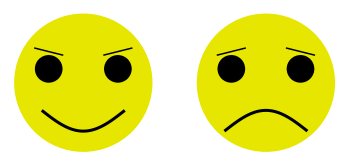

In [ ]:
import matplotlib.pyplot as pp
import numpy as np
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
  'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
  'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
  'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
  'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
  base_face()
  for i in face:
    patches[i]()
  pp.axis('scaled')
  pp.axis('off')

f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

What defines a face is thus just a list of these keys. For example above I'm drawing `['smile', 'left_eb_down', 'right_eb_down']` on the left and `['frown', 'left_eb_up', 'right_eb_up']` on the right.

What we next need to define is a **reward function**. Here I'd like to only reward valid faces, therefore if there are missing parts or two overlapping parts, such as both `smile` and `frown` the reward is 0. I'd also like to generate smiley faces more often than sad faces, and so I'm giving the former a reward of 2, and the latter a reward of 1.

Remember that we're aiming for a model which respects $p(x) \propto R(x)$, this means in this case that, all other face parts being equal, we should get exactly twice as many smiles as frowns!

In [ ]:
def has_overlap(face):
  # Can't have two overlapping eyebrows!
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True
  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True
  # Can't have two overlapping mouths!
  if 'smile' in face and 'frown' in face:
    return True
  return False

def face_reward(face):
  if has_overlap(face):
    return 0
  eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
  # Must have exactly two eyebrows
  if sum([i in face for i in eyebrows]) != 2:
    return 0
  # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
  if 'smile' in face:
    return 2
  if 'frown' in face:
    return 1  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
  return 0


Now that we've defined a reward function, let's take a look at what the state space looks like.

By state space, we mean the **space of intermediate constructions**, i.e. in this case this will include both partially created faces and fully created faces. For this tutorial we refer to these states as $s$, and to the full constructions as both $x$ and $s$ interchangeably (because $\mathcal{X} \subset \mathcal{S}$).

As you can see, we start with a base face that has just two eyes and we progressively add all possible patches that make a valid face. We call one such construction path from bottom to top a _trajectory_ or an _episode_.

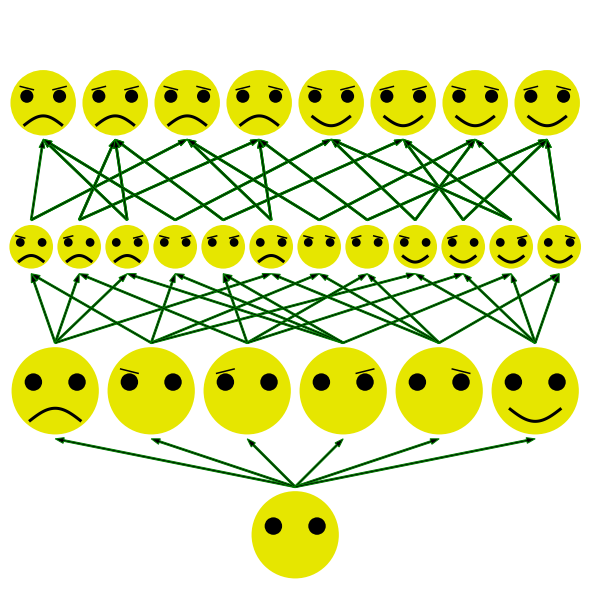

In [ ]:
#@title
enumerated_states = []
transitions = []
def recursively_enumerate(s):
  if has_overlap(s):
    return
  for i in sorted_keys:
    if i not in s:
      recursively_enumerate(s+[i])
  enumerated_states.append(s)
  transitions.append((s[:-1], s))
recursively_enumerate([])
unique = []
for i in map(set, enumerated_states):
  if i not in unique:
    unique.append(i)
enumerated_states = sorted(map(tuple, unique))

lens = [len([i for i in enumerated_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in enumerated_states if len(i) == j]) for j in range(4)]
f = pp.figure(figsize=(8, 8))
def face_hash(face):
  return tuple([i in face for i in sorted_keys])
face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
  for j, face in enumerate(level):
    ax = f.add_axes([j/L, i/4, 1/L, 1/6])
    draw_face(face)
    face2pos[face_hash(face)] = (j/L+0.5/L, i/4)
ax = f.add_axes([0,0,1,1])
pp.sca(ax)
pp.gca().set_facecolor((0,0,0,0))
pp.xlim(0,1)
pp.ylim(0,1)
for a, b in transitions[1:]:
  pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
  if not len(b): continue
  lb = int(pb[1] * 4)
  la = int(pa[1] * 4)
  ws = [1/6,1/6,0.13,0.11]
  pp.arrow(pa[0],pa[1]+ws[la],pb[0]-pa[0],pb[1]-pa[1]-ws[lb], head_width=0.01, width=0.003, ec=(0.,0.5,0),fc=(0,0,0),
           length_includes_head=True)
  pp.axis('off')


Think of the directed acyclic graph (DAG) above as the unrolling of the `for` loop of the generation process and the visualization of all possible paths. In Reinforcement Learning we'd call this the Markov Decision Process (MDP).

What we're interested in is a _policy_, something that will tell us at each step what action to take (what patch to add). Since we are interested in learning a distribution, the policy itself will be a distribution over actions (possible patches to add) which is typically written $\pi(a|s)$ in RL, but which we'll call $P_F$ ($F$ for forward) here. We'll call these arrows above, the $(s,s')$ pairs (or equivalently, $(s,a)$ pairs), _edges_, and the set of all edges $\mathcal{E}$.

The main idea behind GFlowNet is to interpret the DAG as a **flow network**, and to think of each edge as a pipe through which some amount of water, or particles, _flows_. We then want to _find_ a flow where, (a) flow is preserved, (b) the flow coming into a terminal state (a finished object) is equal to its reward (and in fact every non-terminal state _does not have any reward_).

("network" here thus does _not_ refer to a _neural_ network architecture, it's not the "Net" in "ConvNet", it refers to the MDP. Naming is hard 😉)

A central finding of the first GFlowNet paper is that if we match to each edge a _flow_, $F(s,s')>0$, and that this flow respects the following property:
$$\forall s', \sum_{s: (s,s')\in\mathcal{E}} F(s,s') = R(s') + \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')$$
which ensures _flow consistency_, then if we define the following policy:
$$P_F(s'|s) = \frac{F(s, s')}{\sum_{s''}F(s, s'')}$$
and sample trajectories (paths through the DAG) using this policy, we will sample terminal states (finished objects $x$) with probability:
$$p(x) \propto R(x)$$

### Building and training a flow model with flow-matching

We'll now setup a model and train it with the _flow-matching_ loss, introduced in [Flow Network based Generative Models for Non-Iterative Diverse Candidate Generation, Emmanuel Bengio, Moksh Jain, Maksym Korablyov, Doina Precup, Yoshua Bengio](https://arxiv.org/abs/2106.04399)

Now that we know we want to predict edge flows, we need to define some model which does that. We could use a model that is a function of a pair of states, but that's not too efficient (exercise left to the reader ;). Instead we'll take inspiration from RL and model a function of a single state which outputs multiple predictions at once, the flow for each possible child of that state.

In other words, we train a model `F(state)` which outputs a vector which is indexed by the action used to reach a child of `state`, i.e. $F(s,s')$ is `F(s)[a]` if `a` leads from $s$ to $s'$ (e.g. `a` can be, "add a raised eyebrow").

In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm

# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
  return torch.tensor([i in face for i in sorted_keys]).float()

class FlowModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # We encoded the current state as binary vector, for each patch the associated
    # dimension is either 0 or 1 depending on the absence or precense of that patch.
    # Therefore the input dimension is 6 for the 6 patches.
    self.mlp = nn.Sequential(nn.Linear(6, num_hid), nn.LeakyReLU(),
                             # We also output 6 numbers, since there are up to
                             # 6 possible actions (and thus child states), but we
                             # will mask those outputs for patches that are
                             # already there.
                             nn.Linear(num_hid, 6))
  def forward(self, x):
    # We take the exponential to get positive numbers, since flows must be positive,
    # and multiply by (1 - x) to give 0 flow to actions we know we can't take
    # (in this case, x[i] is 1 if a feature is already there, so we know we
    # can't add it again).
    F = self.mlp(x).exp() * (1 - x)
    return F

Another important thing we need to define is how we deal with parents. Since we'll be using the flow-matching objective to make the _flow consistency_ equation respected, we need to be able to enumerate the $(s, s')$ pairs that are "parents" of $s'$.

In the left sum $$\sum_{s: (s,s')\in\mathcal{E}} F(s,s') = R(s') + \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')$$
the set $\{s: (s,s')\in\mathcal{E}\}$ is the set of parents of $s'$, while in the right sum, it is the set of children of $s'$. Since we're parameterizing $F$ with something that outputs a vector, computing the sum over children flows on the right is easy, we simply take `F(s').sum()`. But on the left, we need to do one forward pass for each parent to basically take `sum([F(ps)[pa] for ps, pa in parents(s')])` (we will see later in the tutorial that this is avoidable).

In [ ]:
def face_parents(state):
  parent_states = []  # states that are parents of state
  parent_actions = []  # actions that lead from those parents to state
  for face_part in state:
    # For each face part, there is a parent without that part
    parent_states.append([i for i in state if i != face_part])
    # The action to get there is the corresponding index of that face part
    parent_actions.append(sorted_keys.index(face_part))
  return parent_states, parent_actions

Finally, to actually train the model we'll use the simplest differentiable loss possible, by just turning the above equation into a mean squared error (there are better losses, we will get to it):
$$L(s') = \left(\sum_{s: (s,s')\in\mathcal{E}} F(s,s') - R(s') - \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')\right)^2$$

We're now ready to instantiate and train the model.

To do that, we'll let the model generate its own data by following its own policy (based on edge flow predictions), and simply train on that data. Let's go through this code and then run it for a minute.

In [ ]:
# Instantiate model and optimizer
F_sa = FlowModel(512)
opt = torch.optim.Adam(F_sa.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
losses = []
sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 4
for episode in tqdm.tqdm(range(50000), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict F(s, a)
  edge_flow_prediction = F_sa(face_to_tensor(state))
  for t in range(3):
    # The policy is just normalizing, and gives us the probability of each action
    policy = edge_flow_prediction / edge_flow_prediction.sum()
    # Sample the action
    action = Categorical(probs=policy).sample()
    # "Go" to the next state
    new_state = state + [sorted_keys[action]]

    # Now we want to compute the loss, we'll first enumerate the parents
    parent_states, parent_actions = face_parents(new_state)
    # And compute the edge flows F(s, a) of each parent
    px = torch.stack([face_to_tensor(p) for p in parent_states])
    pa = torch.tensor(parent_actions).long()
    parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
    # Now we need to compute the reward and F(s, a) of the current state,
    # which is currently `new_state`
    if t == 2:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = face_reward(new_state)
      # and since there are no children to this state F(s,a) = 0 \forall a
      edge_flow_prediction = torch.zeros(6)
    else:
      # Otherwise we keep going, and compute F(s, a)
      reward = 0
      edge_flow_prediction = F_sa(face_to_tensor(new_state))

    # The loss as per the equation above
    flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
    minibatch_loss += flow_mismatch  # Accumulate
    # Continue iterating
    state = new_state

  # We're done with the episode, add the face to the list, and if we are at an
  # update episode, take a gradient step.
  sampled_faces.append(state)
  if episode % update_freq == 0:
    losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0


100%|█| 50000/50000 [01:24<00:00, 594.56


We now trained the model for a little while. It's not perfect but the loss seems low enough:

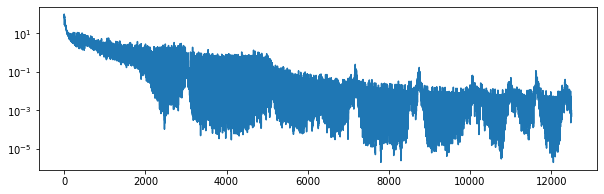

In [ ]:
pp.figure(figsize=(10,3))
pp.plot(losses)
pp.yscale('log')

Let's see what kind of faces the model is generating. Remember that we set the reward of smiling faces to 2 and the reward of frowny faces to 1. Since there are 4 possible smile and frown faces respectively (i.e. an equal number), we should expect there to be 2/3 smiling faces and 1/3 frowny faces when sampling from the model:

Ratio of faces with a smile: 0.6640625
Ratio of valid faces: 0.9453125


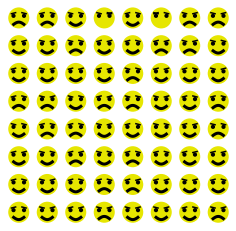

In [ ]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

We can now even visualize the edge flows:

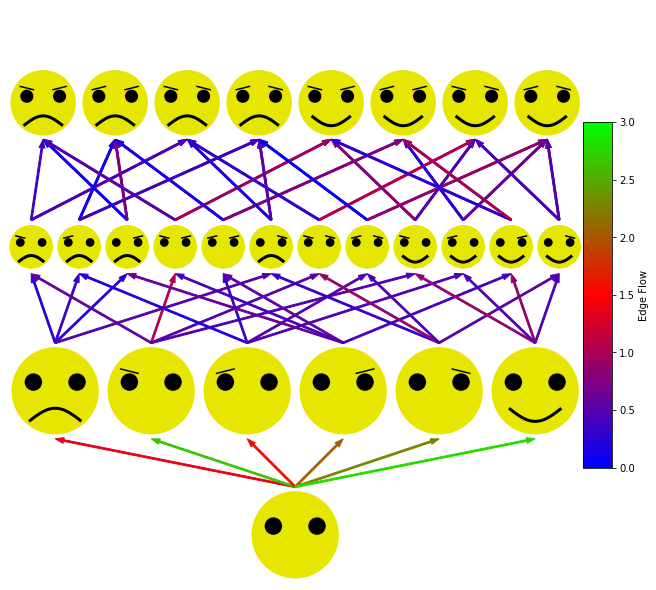

In [ ]:
#@title
import matplotlib.cm as cm
lens = [len([i for i in enumerated_states if len(i) == j]) for j in range(4)]
levels = [sorted([i for i in enumerated_states if len(i) == j]) for j in range(4)]
f = pp.figure(figsize=(8, 8))
def face_hash(face):
  return tuple([i in face for i in sorted_keys])
face2pos = {}
for i, (level, L) in enumerate(zip(levels, lens)):
  for j, face in enumerate(level):
    ax = f.add_axes([j/L, i/4, 1/L, 1/6])
    draw_face(face)
    face2pos[face_hash(face)] = (j/L+0.5/L, i/4)
    Fstate = F_sa(torch.tensor(face_hash(face)).float())
    #print(face, Fstate.data)
ax = f.add_axes([0,0,1,1])
pp.sca(ax)
pp.gca().set_facecolor((0,0,0,0))
pp.xlim(0,1)
pp.ylim(0,1)
for a, b in transitions[1:]:
  if not len(b):
    continue
  pa, pb = face2pos[face_hash(a)], face2pos[face_hash(b)]
  lb = int(pb[1] * 4)
  Fstate = F_sa(torch.tensor(face_hash(a)).float())
  Fa = Fstate[sorted_keys.index([i for i in b if i not in a][0])].item()
  c = cm.brg(Fa/3)
  lb = int(pb[1] * 4)
  la = int(pa[1] * 4)
  ws = [1/6,1/6,0.13,0.11]
  pp.arrow(pa[0],pa[1]+ws[la],pb[0]-pa[0],pb[1]-pa[1]-ws[lb], head_width=0.01, width=0.003, ec=c,fc=c,
           length_includes_head=True)
  pp.axis('off')
ax = f.add_axes([1, 0.2, 0.05, 0.6])
pp.sca(ax)
f.colorbar(cm.ScalarMappable(norm=cm.colors.Normalize(vmin=0, vmax=3), cmap=cm.brg), cax=ax, label='Edge Flow');


One interesting side effect of training a GFlowNet model is that the flow of the initial state _is the partition function_. $F(s_0)$ is the sum of all rewards in the network (in the state space) since, in terms of flows, it is the unique source to all the sinks (which each sink in $R(x)$ flow).

Since we have 4 terminal smiling states and 4 frowny ones with rewards 2 and 1 respectively, the total reward is $8 + 4 = 12$. Let's see if the model has learned that:

In [ ]:
F_sa(face_to_tensor([])).sum()

tensor(12.7352, grad_fn=<SumBackward0>)

Not quite, but close enough. Perhaps we can do better?

### Trajectory Balance

[Trajectory Balance: Improved Credit Assignment in GFlowNets, Nikolay Malkin, Moksh Jain, Emmanuel Bengio, Chen Sun, Yoshua Bengio](https://arxiv.org/abs/2201.13259)

So far we've thought of flow-consistency very locally by considering a single state and looking at all the flow coming into that state and out of that state.

Another point of view we can adopt is to think of the flow of a _trajectory_ $\tau$. If you think of all the possible paths from $s_0$ the initial state to some state $s$, they can all be "assigned" some amount of flow (just like we "assigned" flows to edges earlier). Just like we wanted all incoming flows to a terminal state to be equal to its reward $R(x)$, we can say we want all the trajectory flows that go to a state to equal its reward. More generally we can write
$$F(s) = \sum_{\tau, s\in\tau} F(\tau)$$

Let's also write the probability of a particular trajectory as the product of its policy steps:
$$P(\tau) = \prod_{(s,s') \in \tau} P_F(s'|s) =\frac{1}{Z}F(\tau)$$
we note the relationship of $P(\tau)$ with $F(\tau)$: "what fraction of the total flow $Z$ goes through $\tau$?".

Yet another equivalent point of view we can adopt is to think of _backward_ trajectories. We can define $P_B$ as a distribution over the parents of a state, with the following property

$$P(\tau) = \prod_{(s,s') \in \tau} P_B(s|s')$$

With a bit of rearranging (see paper), let $\tau=(s_0,...,s_n=x)$ we end up with this equality:


$$Z \prod_{t} P_F(s_{t+1}|s_t) = R(x)\prod_t P_B(s_t|s_{t+1})$$


Here's an intuitive view of what this means. Since all the incoming flow to a terminal state must be preserved, you can think of it being "split up" into different flows (one for each parent of that state). Since $P_B$ is a distribution, sums to 1, it does that splitting.

> $R(x)\prod_t P_B(s_t|s_{t+1})$ represents "what fraction of the reward goes through this particular trajectory?"

The other side of this equation is also some kind of allocation, splitting up, but of the partition function $Z$.

> $Z \prod_{t} P_F(s_{t+1}|s_t)$ represents "what fraction of the partition function goes through this trajectory?"

What the equality enforces is simply that those two quantities are equal.


#### Implementing Trajectory Balance

Since we assume $R(x)$ is given, we'll now need to estimate $Z$, $P_B$ and $P_F$.

In the last exercise, we modeled $F(s,a)$ directly, but in practice, as the number of states grows, this is not ideal. Instead, implementations of GFlowNet typically model $\log F(s, a)$ (just like we typically train classifiers with a logsoftmax rather than predicting the probabilities directly).

We will do the same thing here and actually estimate $\log Z$ as well as the logits of $P_B$ and $P_F$.

In [ ]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # The input dimension is 6 for the 6 patches.
    self.mlp = nn.Sequential(nn.Linear(6, num_hid), nn.LeakyReLU(),
                             # We now output 12 numbers, 6 for P_F and 6 for P_B
                             nn.Linear(num_hid, 12))
    # log Z is just a single number
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    logits = self.mlp(x)
    # Slice the logits, and mask invalid actions (since we're predicting
    # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
    P_F = logits[..., :6] * (1 - x) + x * -100
    P_B = logits[..., 6:] * x + (1 - x) * -100
    return P_F, P_B

Just like we turned the flow-matching equation into a MSE loss, we will use the following loss for a trajectory:
$$L(\tau) = \left(\log \frac{Z_\theta \prod_t P_F(s_{t+1}|s_t;\theta)}{R(x)\prod_t P_B(s_t|s_{t+1}; \theta)} \right)^2$$

or equivalently
$$L(\tau) = \left(\log Z_\theta + \sum_t \log P_F(s_{t+1}|s_t;\theta) - \log R(x) - \sum_t \log P_B(s_t|s_{t+1}; \theta) \right)^2$$

You may notice that in this loss there is no need to compute parents! In the current toy example this won't make a difference, but when generating complex objects this saves us O(average number of parents) forward passes.

Again we will roll out trajectories, then compute the loss after each trajectory and take gradient steps at some frequency. Let's train the model for a minute.

In [ ]:
# Instantiate model and optimizer
model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

# Let's keep track of the losses and the faces we sample
tb_losses = []
tb_sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 2

logZs = []
for episode in tqdm.tqdm(range(50000), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict P_F, P_B
  P_F_s, P_B_s = model(face_to_tensor(state))
  total_P_F = 0
  total_P_B = 0
  for t in range(3):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state + [sorted_keys[action]]
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == 2:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = torch.tensor(face_reward(new_state)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(face_to_tensor(new_state))
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy. I.e., for P_F action
    # `i` just added the face part `i`, for P_B we'll assume action `i` removes
    # face part `i`, this way we can just keep the same indices.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  minibatch_loss += loss

  # Add the face to the list, and if we are at an
  # update episode, take a gradient step.
  tb_sampled_faces.append(state)
  if episode % update_freq == 0:
    tb_losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs.append(model.logZ.item())


100%|█| 50000/50000 [01:51<00:00, 448.68


Once again we can plot the loss and see that it's generally going down. We could do much better in terms of hyperparameters or learning rate scheduling, but for the purposes of this tutorial we'll leave it at that.

Another thing we can see is that the value of $Z$ we're estimating reaches around 12 once again, confirming that the model "learned about" all possible rewards.

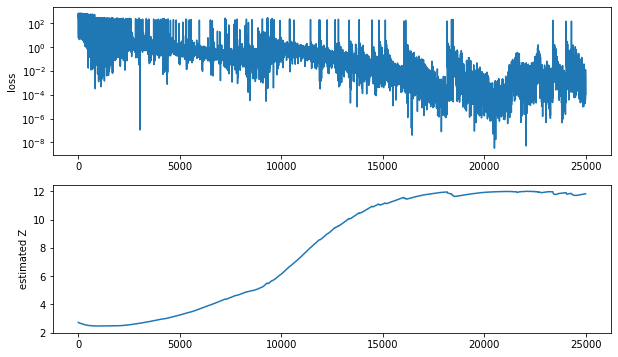

In [ ]:
f, ax = pp.subplots(2, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z');

This is the final value we get:

In [ ]:
model.logZ.exp()

tensor([11.8310], grad_fn=<ExpBackward0>)

And we can once again check that we get about 2/3 of smiley samples and mostly valid samples.

Ratio of faces with a smile: 0.6171875
Ratio of valid faces: 1.0


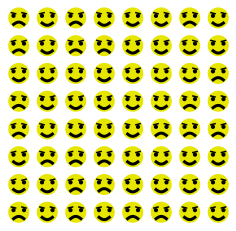

In [ ]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in tb_sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in tb_sampled_faces[-128:]]) / 128)
for i, face in enumerate(tb_sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

## What next?

There are many more things and subtleties that can underlie implementing GFNs. In particular we didn't touch on:
- 'stop' actions; in many scenarios one may want to build objects of various lengths. For example here we could choose to add a nose or not, and either might be valid--in this case one of the actions the agent needs to be able to take is to stop at any time.
- off-policy training; it is possible to train GFNs on any distribution of data (as long as it has full support, i.e. in the limit every $x$ is seen). This means that we can choose more or less exploratory policies (by example taking actions randomly or changing the temperature of the categorical). This also means we can train from a dataset (this may help the model find interesting examples in sparse cases when most of the state space has $R\approx 0$).
- generating graphs and more complex objects; this is a place where GFNs might really shine, but it comes with several challenges, such as having a variable action space, having to use graph NNs or transformers--see below for links to implementations on graphs.
- temperature & explore/exploit; it is possible to use an inverse temperature parameter $\beta$ to make the reward $\hat R(x) = R(x)^\beta$ more or less peaky. It is even possible to train models which use $\beta$ as an input.

### Further reading

Once again, you may want to checkout the more mathematically complete [GFN tutorial](https://tinyurl.com/gflownet-tutorial) by Yoshua to learn more, or take a dive into the papers I've already linked to.

There are many directions that GFlowNets are taking, and I'm sure this list is already incomplete, but here are some recent papers that you might be interested in (see [here](https://github.com/zdhNarsil/Awesome-GFlowNets) for an even more complete list):
- [Learning GFlowNets from partial episodes for improved convergence and stability](https://arxiv.org/abs/2209.12782); Kanika Madan, Jarrid Rector-Brooks, Maksym Korablyov, Emmanuel Bengio, Moksh Jain, Andrei Nica, Tom Bosc, Yoshua Bengio, Nikolay Malkin  
 Shows a better objective than Trajectory Balance is possible by considering subtrajectories.
- [Generative Flow Networks for Discrete Probabilistic Modeling](https://arxiv.org/abs/2202.01361), Dinghuai Zhang, Nikolay Malkin, Zhen Liu, Alexandra Volokhova, Aaron Courville, Yoshua Bengio  
  Shows it's possible to jointly learn an energy function and a generator from data with GFN.
- [Bayesian Structure Learning with Generative Flow Networks](https://arxiv.org/abs/2202.13903), Tristan Deleu, António Góis, Chris Emezue, Mansi Rankawat, Simon Lacoste-Julien, Stefan Bauer, Yoshua Bengio  
  Shows it's possible to use GFNs to generate causal graphs.
- [Biological Sequence Design with GFlowNets](https://arxiv.org/abs/2203.04115), Moksh Jain, Emmanuel Bengio, Alex-Hernandez Garcia, Jarrid Rector-Brooks, Bonaventure F. P. Dossou, Chanakya Ekbote, Jie Fu, Tianyu Zhang, Micheal Kilgour, Dinghuai Zhang, Lena Simine, Payel Das, Yoshua Bengio  
  Shows it's possible to generate interesting and diverse biological sequences with GFN.
- [Unifying Generative Models with GFlowNets](https://arxiv.org/abs/2209.02606),
Dinghuai Zhang, Ricky T. Q. Chen, Nikolay Malkin, Yoshua Bengio  
  Explores common traits between GFNs, generative models, and other methods that approximate a distribution.

There are also many code repositories that may be of interest:
- https://github.com/GFNOrg/gflownet is the initial gflownet implementation on **molecules** and grids
  - https://github.com/recursionpharma/gflownet, a more efficient and organized reimplementation I recently wrote (and with more features); this is also **molecule** code
- https://github.com/MJ10/BioSeq-GFN-AL **Biological sequence design** code
- https://github.com/GFNOrg/EB_GFN Code for **discrete probabilistic modeling**
- https://github.com/tristandeleu/jax-dag-gflownet Code for **Bayesian structure learning**
- If you are a Mila student and reading this tutorial, comme see us on #gflownet we have more experimental stuff 😉

Finally, feel free to contact me with comments, requests, or things you'd like to see clarified at bengioe@gmail.com.